In [1]:
import pandas as pd
import numpy as np
import kaggle

import os
import sys
from zipfile import ZipFile

from scipy.io import wavfile
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
!kaggle datasets download -d "kinguistics/heartbeat-sounds"


  0%|          | 0.00/110M [00:00<?, ?B/s]
  1%|          | 1.00M/110M [00:00<01:07, 1.68MB/s]
  2%|▏         | 2.00M/110M [00:01<01:03, 1.78MB/s]
  3%|▎         | 3.00M/110M [00:01<01:03, 1.76MB/s]
  4%|▎         | 4.00M/110M [00:02<01:03, 1.76MB/s]
  5%|▍         | 5.00M/110M [00:02<01:01, 1.80MB/s]
  5%|▌         | 6.00M/110M [00:03<00:59, 1.83MB/s]
  6%|▋         | 7.00M/110M [00:04<01:05, 1.66MB/s]
  7%|▋         | 8.00M/110M [00:04<01:05, 1.65MB/s]
  8%|▊         | 9.00M/110M [00:05<01:05, 1.61MB/s]
  9%|▉         | 10.0M/110M [00:06<01:04, 1.63MB/s]
 10%|▉         | 11.0M/110M [00:06<01:02, 1.66MB/s]
 11%|█         | 12.0M/110M [00:07<01:02, 1.63MB/s]
 12%|█▏        | 13.0M/110M [00:08<01:00, 1.67MB/s]
 13%|█▎        | 14.0M/110M [00:08<01:01, 1.65MB/s]
 14%|█▎        | 15.0M/110M [00:09<00:58, 1.70MB/s]
 15%|█▍        | 16.0M/110M [00:09<00:55, 1.77MB/s]
 15%|█▌        | 17.0M/110M [00:10<00:52, 1.85MB/s]
 16%|█▋        | 18.0M/110M [00:10<00:52, 1.85MB/s]
 17%|█▋        | 19.

In [2]:
from zipfile import ZipFile
file_name = "heartbeat-sounds.zip"
with ZipFile(file_name, 'r') as zip_file:
  zip_file.printdir()
  print('Extracting all the files now...')
  zip_file.extractall()
  print('Done!')

File Name                                             Modified             Size
set_a.csv                                      2019-09-20 02:24:46         7031
set_a/Aunlabelledtest__201012172010.wav        2019-09-20 02:24:46       793878
set_a/Aunlabelledtest__201101051105.wav        2019-09-20 02:24:48       695618
set_a/Aunlabelledtest__201101061552.wav        2019-09-20 02:24:48       527066
set_a/Aunlabelledtest__201101091156.wav        2019-09-20 02:24:48       793878
set_a/Aunlabelledtest__201101110659.wav        2019-09-20 02:24:48       667842
set_a/Aunlabelledtest__201101152256.wav        2019-09-20 02:24:48       693436
set_a/Aunlabelledtest__201101220549.wav        2019-09-20 02:24:50       793878
set_a/Aunlabelledtest__201101241434.wav        2019-09-20 02:24:50       793878
set_a/Aunlabelledtest__201102081033.wav        2019-09-20 02:24:50       628780
set_a/Aunlabelledtest__201102081045.wav        2019-09-20 02:24:50       759974
set_a/Aunlabelledtest__201102200848.wav 

In [3]:
set_a = pd.read_csv("./set_a.csv")
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [4]:
set_b_directory_list = os.listdir("./set_b")

file_label = []
file_path = []

for file in set_b_directory_list:
    part = file.split('_')
    if part[0] == 'extrastole':
        file_path.append('set_b/'+file)
        file_label.append('extrastole')
    elif part[0] == 'murmur':
        file_path.append('set_b/'+file)
        file_label.append('murmur')
    elif part[0] == 'normal':
        file_path.append('set_b/'+file)
        file_label.append('normal')
label_df = pd.DataFrame(file_label, columns=['label'])
path_df = pd.DataFrame(file_path, columns=['fname'])
set_b = pd.concat([path_df, label_df], axis=1)
set_b.head()

fname       label
0  set_b/extrastole__127_1306764300147_C2.wav  extrastole
1   set_b/extrastole__128_1306344005749_A.wav  extrastole
2   set_b/extrastole__130_1306347376079_D.wav  extrastole
3  set_b/extrastole__134_1306428161797_C1.wav  extrastole
4   set_b/extrastole__138_1306762146980_B.wav  extrastole

In [5]:
set_a.drop(["sublabel","dataset"],axis="columns",inplace=True)
data_ab = pd.concat([set_a, set_b])
data_ab = data_ab.dropna()
data_ab = data_ab.reset_index()
data_ab.drop(["index"],axis="columns",inplace=True)
data_ab

fname     label
0          set_a/artifact__201012172012.wav  artifact
1          set_a/artifact__201105040918.wav  artifact
2          set_a/artifact__201105041959.wav  artifact
3          set_a/artifact__201105051017.wav  artifact
4          set_a/artifact__201105060108.wav  artifact
..                                      ...       ...
580  set_b/normal__296_1311682952647_A1.wav    normal
581  set_b/normal__296_1311682952647_A2.wav    normal
582   set_b/normal__298_1311685888900_B.wav    normal
583   set_b/normal__299_1311770522820_C.wav    normal
584  set_b/normal__300_1311772096120_C1.wav    normal

[585 rows x 2 columns]

In [6]:
data_ab.describe()

fname   label
count                                     585     585
unique                                    585       5
top     set_b/normal__227_1308594233667_B.wav  normal
freq                                        1     351

In [7]:
data_ab.isnull().sum()

fname    0
label    0
dtype: int64

In [8]:
def create_waveplot(data, samplingrate, label:str):
    plt.figure(figsize=(14,4))
    plt.title(f"Waveplot audio untuk kondisi jantung : {label}", fontsize=25, pad=20)
    librosa.display.waveshow(data, sr = samplingrate)
    plt.show()

In [9]:
print("Pembagian dataset:")
print(f"  - data a = {len(data_ab[data_ab['fname'].str.contains('set_a/')])}")
print(f"  - data b = {len(data_ab[data_ab['fname'].str.contains('set_b/')])}")

Pembagian dataset:
  - data a = 124
  - data b = 461


In [10]:
print("Jumlah label kondisi jantung =",str(len(data_ab.label.unique())),"kategori, diantaranya:")

for i in data_ab.label.unique():
    print(f"- {i}\t: {data_ab['label'].value_counts()[i]}")

Jumlah label kondisi jantung = 5 kategori, diantaranya:
- artifact	: 40
- extrahls	: 19
- murmur	: 129
- normal	: 351
- extrastole	: 46


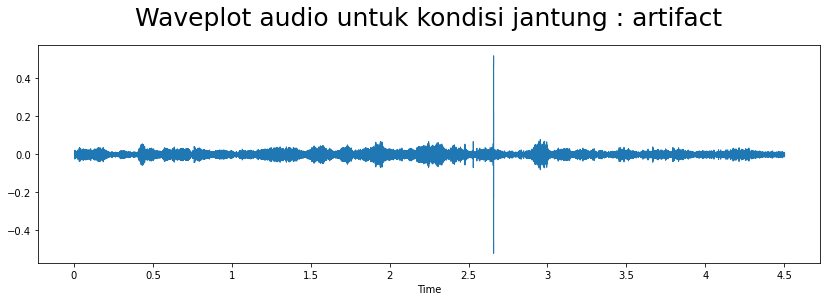

In [11]:
path = data_ab.fname[data_ab.label==data_ab.label.unique()[0]][19]
data = librosa.load(path)[0]
rate = wavfile.read(path)[0]
create_waveplot(data, rate, data_ab.label.unique()[0])
Audio(path)

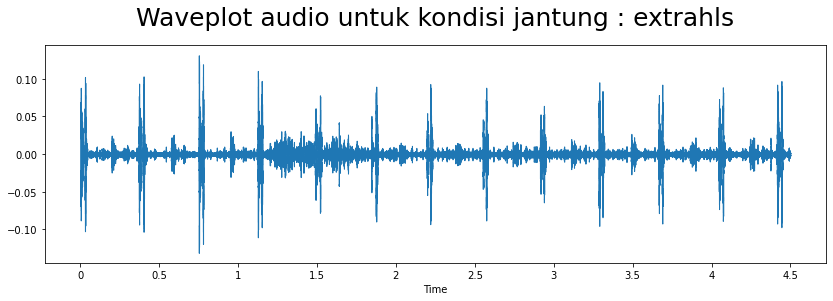

In [12]:
path = data_ab.fname[data_ab.label==data_ab.label.unique()[1]][50]
data = librosa.load(path)[0]
rate = wavfile.read(path)[0]
create_waveplot(data, rate, data_ab.label.unique()[1])
Audio(path)

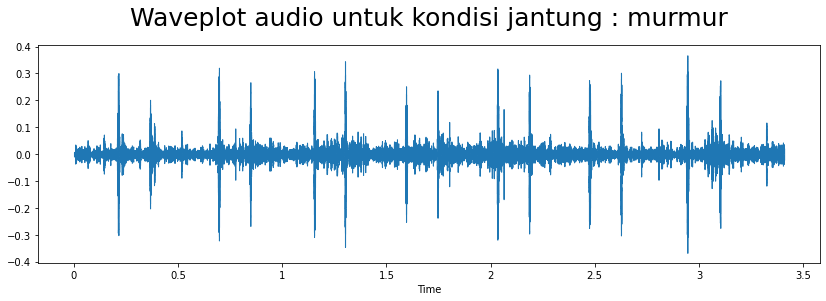

In [13]:
path = data_ab.fname[data_ab.label==data_ab.label.unique()[2]][63]
data = librosa.load(path)[0]
rate = wavfile.read(path)[0]
create_waveplot(data, rate, data_ab.label.unique()[2])
Audio(path)

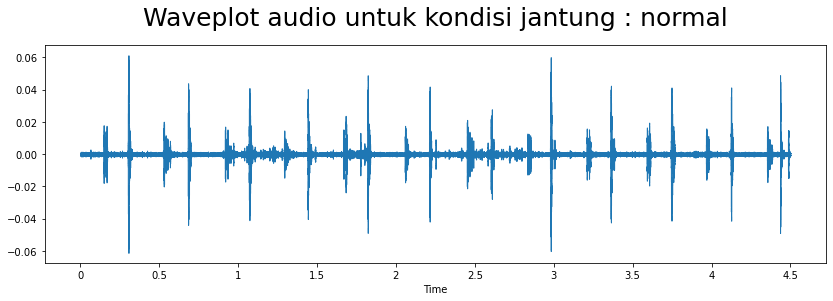

In [14]:
path = data_ab.fname[data_ab.label==data_ab.label.unique()[3]][97]
data = librosa.load(path)[0]
rate = wavfile.read(path)[0]
create_waveplot(data, rate, data_ab.label.unique()[3])
Audio(path)

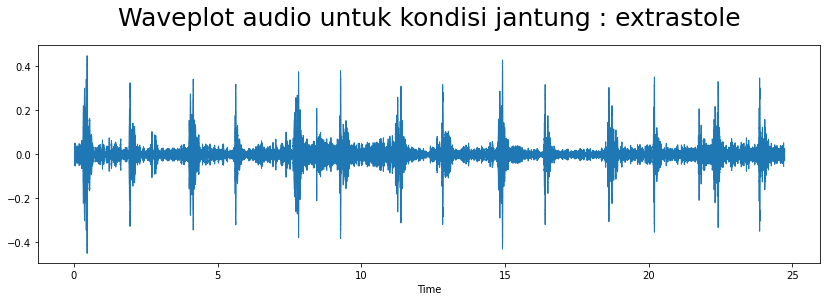

In [15]:
path = data_ab.fname[data_ab.label==data_ab.label.unique()[4]][146]
data = librosa.load(path)[0]
rate = wavfile.read(path)[0]
create_waveplot(data, rate, data_ab.label.unique()[4])
Audio(path)

In [16]:
def noise(data):
    noise_value = 0.009*np.random.uniform()*np.amax(data)
    data = data + noise_value*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.6):
    return librosa.effects.time_stretch(data, rate)

def shift(data, samplingrate):
    return np.roll(data,samplingrate/10)

def pitch(data, samplingrate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, samplingrate, pitch_factor)

In [17]:
def extract_features(data, samplerate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=samplerate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=samplerate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=samplerate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data = librosa.load(path)[0]
    rate = wavfile.read(path)[0]
    
    # without augmentation
    res1 = extract_features(data, rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, rate)
    res3 = extract_features(data_stretch_pitch, rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [18]:
X, Y = [], []
for path, label in zip(data_ab.fname, data_ab.label):
    feature = get_features(path)
    for element in feature:
        X.append(element)
        Y.append(label)

In [19]:
Features = pd.DataFrame(X)
Features['label'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.334171  0.806631  0.811606  0.812490  0.806593  0.801355  0.806266   
1  0.486800  0.904307  0.907185  0.920752  0.923669  0.924268  0.846108   
2  0.254290  0.773434  0.772713  0.767308  0.772583  0.743452  0.735164   
3  0.481876  0.881101  0.895938  0.912247  0.864541  0.716675  0.689641   
4  0.373511  0.872814  0.875470  0.886594  0.904173  0.865882  0.802426   

          7         8         9  ...           153           154  \
0  0.821104  0.835369  0.822015  ...  1.370105e-05  1.513303e-05   
1  0.824789  0.840497  0.858974  ...  1.237181e-03  1.283750e-03   
2  0.747722  0.774442  0.776513  ...  3.261285e-06  3.290700e-06   
3  0.711227  0.753043  0.795017  ...  8.318065e-07  7.440415e-07   
4  0.802520  0.822332  0.846891  ...  1.008661e-06  9.421639e-07   

            155           156           157           158           159  \
0  1.521643e-05  1.584535e-05  1.330138e-05  7.983704e-06  3.928206e-06   
1  1.297986e-03  1.268324e-03  1.321761e-03  1.288010e-03  1.282512e-03   
2  3.169040e-06  3.544368e-06  4.145971e-06  3.292718e-06  2.192565e-06   
3  7.146672e-07  7.748853e-07  7.480742e-07  6.476112e-07  4.952706e-07   
4  9.124718e-07  9.821522e-07  9.644114e-07  8.484663e-07  7.140936e-07   

            160           161     label  
0  1.817778e-06  2.201089e-07  artifact  
1  1.267769e-03  1.266317e-03  artifact  
2  6.270350e-07  4.149805e-08  artifact  
3  2.181541e-07  1.793713e-08  artifact  
4  4.262054e-07  2.242905e-07  artifact  

[5 rows x 163 columns]

In [20]:
print("Jumlah data fitur setiap label =",str(len(data_ab.label.unique())),"kategori, diantaranya:")

for i in Features.label.unique():
    print(f"- {i}\t: {Features['label'].value_counts()[i]}")

Jumlah data fitur setiap label = 5 kategori, diantaranya:
- artifact	: 120
- extrahls	: 57
- murmur	: 387
- normal	: 1053
- extrastole	: 138


In [21]:
X = Features.iloc[:,:-1].values
Y = Features['label'].values
enc = OneHotEncoder()
scaler = StandardScaler()
Y_Encode = enc.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [22]:
print(f"Ukuran data fitur : {X.shape}")
print(f"Ukuran data label : {Y_Encode.shape}")

Ukuran data fitur : (1755, 162)
Ukuran data label : (1755, 5)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_Encode, train_size=0.8, random_state=4, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1404, 162), (1404, 5), (351, 162), (351, 5))

In [24]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [25]:
print(f"Ukuran data train : {x_train.shape}")
print(f"Ukuran data test : {x_test.shape}")

Ukuran data train : (1404, 162, 1)
Ukuran data test : (351, 162, 1)


In [26]:
Early_Stopper = EarlyStopping(monitor="loss",patience=3,mode="min")
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.001)
Checkpoint_Model = ModelCheckpoint(monitor="val_accuracy",
                                   mode='max',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   filepath="./modelcheck")

In [27]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(128, kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Conv1D(32, kernel_size=4, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           262400    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 41, 256)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           1

In [28]:
Conv1D_Model = model.fit(x_train, y_train, batch_size=12, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp, Checkpoint_Model])

Epoch 1/50
117/117 [==============================] - 260s 2s/step - loss: 2.3073 - accuracy: 0.4950 - val_loss: 1.3508 - val_accuracy: 0.6097 - lr: 0.0010
Epoch 2/50
117/117 [==============================] - 311s 3s/step - loss: 1.2300 - accuracy: 0.5933 - val_loss: 1.1105 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 3/50
117/117 [==============================] - 240s 2s/step - loss: 1.1533 - accuracy: 0.5940 - val_loss: 1.0537 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 4/50
117/117 [==============================] - 188s 2s/step - loss: 1.0369 - accuracy: 0.6204 - val_loss: 0.9111 - val_accuracy: 0.6752 - lr: 0.0010
Epoch 5/50
117/117 [==============================] - 227s 2s/step - loss: 1.0356 - accuracy: 0.6311 - val_loss: 1.0114 - val_accuracy: 0.6097 - lr: 0.0010
Epoch 6/50
117/117 [==============================] - 200s 2s/step - loss: 0.9858 - accuracy: 0.6425 - val_loss: 1.0293 - val_accuracy: 0.6097 - lr: 0.0010
Epoch 7/50
117/117 [==============================] - 140s 1s/st

In [29]:
Model_Results = model.evaluate(x_test,y_test)

11/11 [==============================] - 12s 1s/step - loss: 0.7012 - accuracy: 0.7379


LOSS		: 70.12%
ACCURACY	: 73.79%


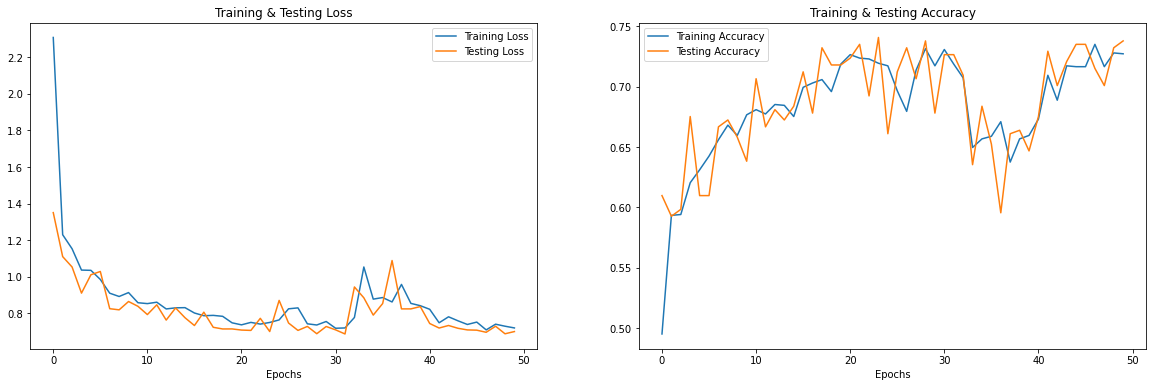

In [30]:
print(f"LOSS\t\t: {round(Model_Results[0]*100,2)}%")
print(f"ACCURACY\t: {round(Model_Results[1]*100,2)}%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = Conv1D_Model.history['accuracy']
train_loss = Conv1D_Model.history['loss']
test_acc = Conv1D_Model.history['val_accuracy']
test_loss = Conv1D_Model.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(pred_test)
y_test = enc.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

Predicted Labels Actual Labels
0           normal        normal
1           normal        normal
2           murmur        murmur
3           normal        normal
4           normal        normal
5         artifact      artifact
6           normal        normal
7           normal        normal
8           normal        normal
9           normal        normal

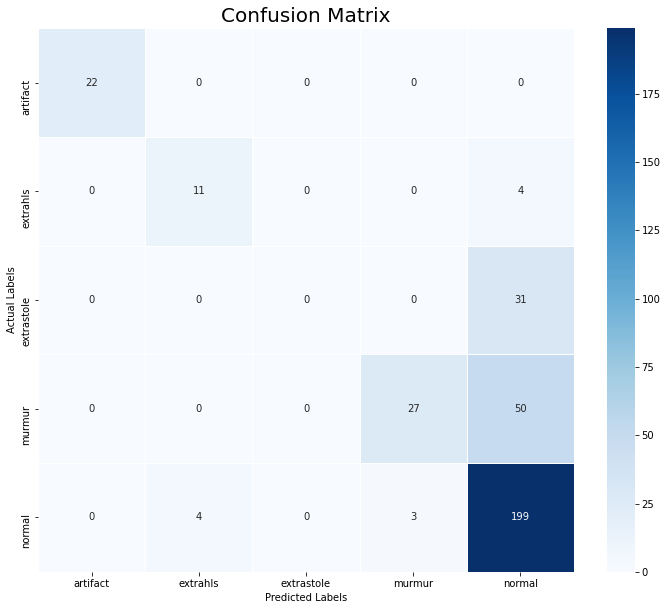

In [33]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in enc.categories_] , columns = [i for i in enc.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=10)
plt.ylabel('Actual Labels', size=10)
plt.show()

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    artifact       1.00      1.00      1.00        22
    extrahls       0.73      0.73      0.73        15
  extrastole       0.00      0.00      0.00        31
      murmur       0.90      0.35      0.50        77
      normal       0.70      0.97      0.81       206

    accuracy                           0.74       351
   macro avg       0.67      0.61      0.61       351
weighted avg       0.70      0.74      0.68       351



In [35]:
model.save('Conv1D_model(rlrp,Checkpoint_Model)')

INFO:tensorflow:Assets written to: Conv1D_model(rlrp,Checkpoint_Model)\assets
